# RIGGS_CM5_Project


## Setup

**Here I set import the needed libraries and upload my dataset. The dataset I have picked for this assignment is a collection of abstract art piceces. I will use this dataset to train a GAN model in the hopes of generating original artwork.**

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
import numpy as np
import PIL
import PIL.Image
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocess

In [ ]:
CODING_SIZE = 100
BATCH_SIZE = 50

data_path = '/content/drive/MyDrive/Colab_Notebooks/savedFiles/Abstract_gallery'

#Import as tf.Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (128,128), batch_size=BATCH_SIZE, shuffle=1000)


Found 2850 files belonging to 1 classes.


In [ ]:
dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>

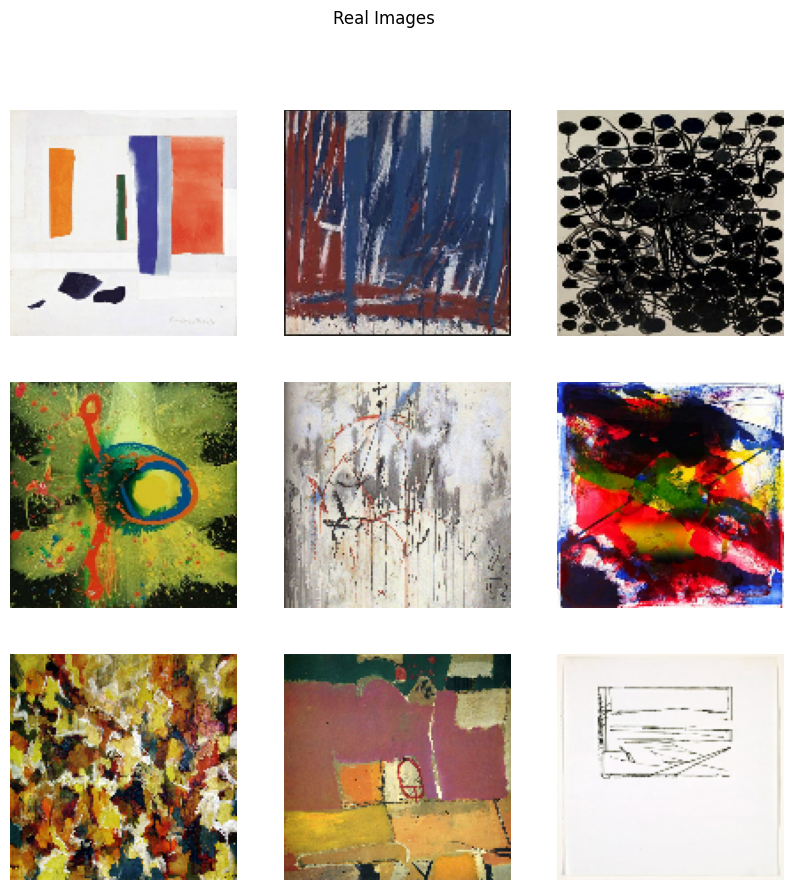

In [ ]:
plt.figure(figsize=(10, 10))
plt.suptitle("Real Images")
for images in dataset:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

**Here use a normalization layer to normalize my images for training.**

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = dataset.map(lambda x: (normalization_layer(x)))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.024790328 1.0


In [ ]:
normalized_ds

<_MapDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>

## GAN Model

**This model is right out of our book. I did experiment with other variations of this model but ran into some difficulties with them. In addition, the amount of training time needed to train GANs is substantial.**

In [ ]:
tf.random.set_seed(34)

CODING_SIZE = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(32 * 32 * 128),
    tf.keras.layers.Reshape([32 , 32, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(4, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2,
                                    padding="same", activation="tanh"),
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2), input_shape=[128, 128, 3]),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])


**Here is what my generator produces prior to training.**

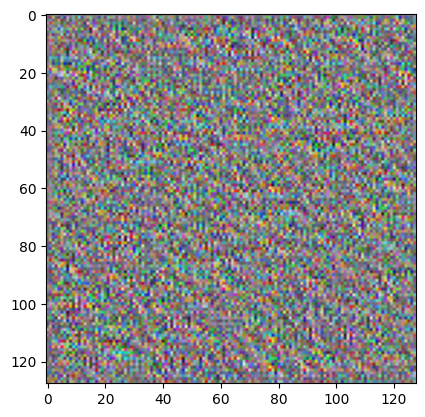

In [ ]:


noise = tf.random.normal([1,CODING_SIZE])
generated_image = generator(noise,training=True)
generated_image = 0.5 * generated_image + 0.5
plt.imshow(generated_image[0])

In [ ]:
generated_image.shape

TensorShape([1, 128, 128, 3])

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    count = 0
    for epoch in range(n_epochs):
        count += 1
        print('start of epoch ', count)
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)


In [ ]:
ganModel = tf.keras.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
ganModel.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:

train_gan(ganModel, normalized_ds, BATCH_SIZE, CODING_SIZE, n_epochs=25)


start of epoch  1
start of epoch  2
start of epoch  3
start of epoch  4
start of epoch  5
start of epoch  6
start of epoch  7
start of epoch  8
start of epoch  9
start of epoch  10
start of epoch  11
start of epoch  12
start of epoch  13
start of epoch  14
start of epoch  15
start of epoch  16
start of epoch  17
start of epoch  18
start of epoch  19
start of epoch  20
start of epoch  21
start of epoch  22
start of epoch  23
start of epoch  24
start of epoch  25


## Result

1/1 [==============================] - 0s 27ms/step


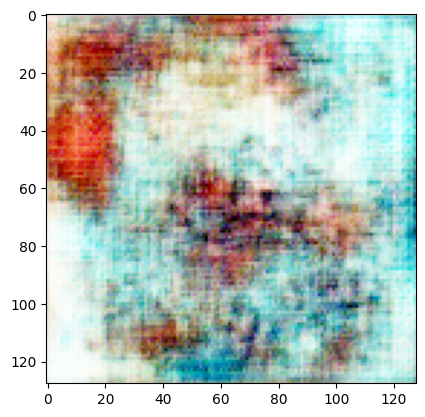

In [ ]:
noise = tf.random.normal(shape=[1, CODING_SIZE])
generated_image = generator.predict(noise)
plt.imshow(generated_image[0])

**I Made sure to save the model for later use.**

In [ ]:
import pickle

fileName = '/content/drive/MyDrive/Colab_Notebooks/savedFiles/generator_1.pkl'

#with open(fileName, 'wb') as file:
#   pickle.dump(generator, file)


In [ ]:
with open(fileName, 'rb') as file:
    loaded_generator = pickle.load(file)

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# 8 images created by trained generator

2/2 [==============================] - 0s 110ms/step


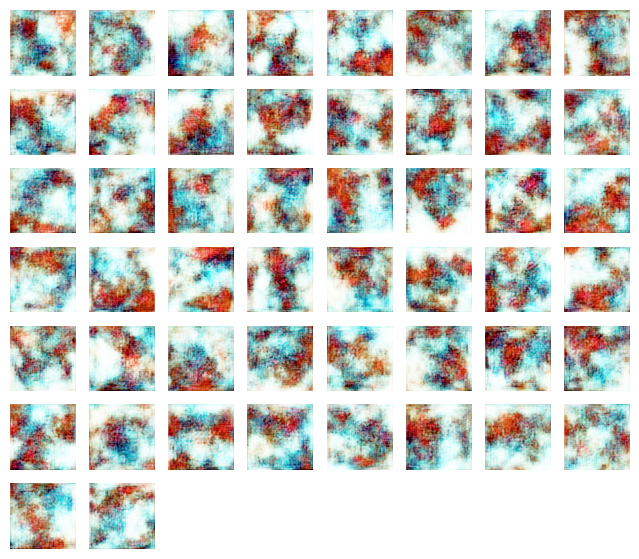

In [ ]:
tf.random.set_seed(42)
noise = tf.random.normal(shape=[BATCH_SIZE, CODING_SIZE])
generated_images = loaded_generator.predict(noise)
plot_multiple_images(generated_images, 8)


**In conclusion. I had a very difficult time with this dataset and trying to format it correctly to use for this assignment but learned a lot in the process. I thought this was a very interesting assignment and I want to play around with this model more to get better results in the future.**